In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

my_dpi = 90

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [213]:
path = '/home/peter/Desktop/results.csv'
df = pd.read_csv(path)
df.shape

(31984, 21)

In [214]:
# Check for missing data
print("%s\n" % (df.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (df.dtypes))

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64


10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object



In [215]:
times = ['5k','10k', '20k','half','25k', '30k', '35k','40k', 'official']
for leg in times:
    df = df.replace(to_replace='-', value='')
    df[leg] = df[leg].convert_objects(convert_numeric=True)

# drop features name, bib etc.
df2 = df[['5k','10k', '20k','half','25k', '30k', '35k','40k', 'official','age',  'overall', 'pace']]

In [216]:
df2['pace0-5'] = df2.loc[:,'5k']/5
df2['pace5-10'] = (df2.loc[:,'10k']-df2.loc[:,'5k'])/5
df2['pace10-20'] = (df2.loc[:,'20k']-df2.loc[:,'10k'])/10
df2['pace20-25'] = (df2.loc[:,'25k']-df2.loc[:,'20k'])/5
df2['pace25-30'] = (df2.loc[:,'30k']-df2.loc[:,'25k'])/5
df2['pace30-35'] = (df2.loc[:,'35k']-df2.loc[:,'30k'])/5
df2['pace35-40'] = (df2.loc[:,'40k']-df2.loc[:,'35k'])/5
df2['half2nd'] = (df2.loc[:,'official']-df2.loc[:,'half'])/21.1
df2['gender'] = df['gender']
df2 = df2.dropna()

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [217]:
maxvalue = df2.iloc[:,0:9].max().max()
minvalue = df2.iloc[:,0:9].min().min()

marathon = (df2.iloc[:,0:9] - minvalue)/(maxvalue - minvalue)

MMS = MinMaxScaler()
MMS.fit(df2['age'])
marathon['age'] = MMS.fit_transform(df2['age'])
MMS.fit(df2['overall'])
marathon['overall'] = MMS.fit_transform(df2['overall'])
MMS.fit(df2['pace'])
marathon['pace'] = MMS.fit_transform(df2['pace'])

maxvalue = df2.iloc[:,12:19].max().max()
minvalue = df2.iloc[:,12:19].min().min()

marathon2 = (df2.iloc[:,12:19] - minvalue)/(maxvalue - minvalue)

/home/peter/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [218]:
marathon = pd.concat([marathon, marathon2], axis=1)

In [219]:
pacemax = marathon.iloc[:,12:19].max(axis = 1)
pacemin = marathon.iloc[:,12:19].min(axis = 1)

In [220]:
marathon['HTW']= pacemax - pacemin

In [233]:
clustorcolormap = {0 : 'red',
                   1 : 'orange',
                   2 : 'yellow',
                   3: 'green', 
                   4: 'blue',
                   5: 'purple', 
                   6:'black',
                   7:'grey',
                   8: 'yellow', 
                   9: 'brown',
                   10: 'pink', 
                   11:'maroon',
                   12:'teal',
                   13:'indigo'}

SEX_COLOR_MAP = {'M' : 'b', 'F' : 'pink'}
gender_color = [SEX_COLOR_MAP[l] for l in df2.gender]
PLACE_COLOR_MAP = {1 : 'yellow', 0 : 'blue'}
df2['winner'] = np.where(df2.overall < 1000, 1, 0)
place_color = [PLACE_COLOR_MAP[x] for x in df2.winner]

In [234]:
tic()
bandwidth = estimate_bandwidth(marathon.values, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(marathon)

mslabel_color = []
for l in ms.labels_:
    mslabel_color.append(clustorcolormap[l])

ms_n_clusters_ = len(np.unique(ms.labels_))

print("Number of clusters estimated by MeanShift: {}".format(ms_n_clusters_))
tac()

Number of clusters estimated by MeanShift: 1
Time passed: 0hour:1min:54sec


In [235]:
def chcktwo(data, feat1, feat2, unscaleddata):
    tic()
    bandwidth = estimate_bandwidth(data[[feat1,feat2]].values, quantile=0.3)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data[[feat1,feat2]])
    
    ms_n_clusters_ = len(np.unique(ms.labels_))
    print("Number of clusters estimated by MeanShift: {}".format(ms_n_clusters_))
    mslabel_color = []
    for l in ms.labels_:
        mslabel_color.append(clustorcolormap[l])
    
    tac()
    
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

    plt.figure(1)
    
    ax1 = plt.subplot(311)
    ax1.scatter(unscaleddata[feat1], unscaleddata[feat2], c = mslabel_color, edgecolors = 'black')
    ax1.set_xlabel(feat1)
    ax1.set_ylabel(feat2)
    
    ax2 = plt.subplot(312)
    ax2.set_title('Gender Coloring')
    ax2.set_xlabel(feat1)
    ax2.set_ylabel(feat2)
    __ = ax2.scatter(unscaleddata[feat1],unscaleddata[feat2], c=gender_color, alpha=0.6, edgecolors = 'black')

    ax3 = plt.subplot(313)
    ax3.set_title('Winner Coloring')
    ax3.set_xlabel(feat1)
    ax3.set_ylabel(feat2)
    __ = ax3.scatter(unscaleddata[feat1],unscaleddata[feat2], c=place_color, alpha=0.6, edgecolors = 'black')
    
    plt.tight_layout(pad=0.4, h_pad=2.0)


Number of clusters estimated by MeanShift: 3
Time passed: 0hour:0min:51sec


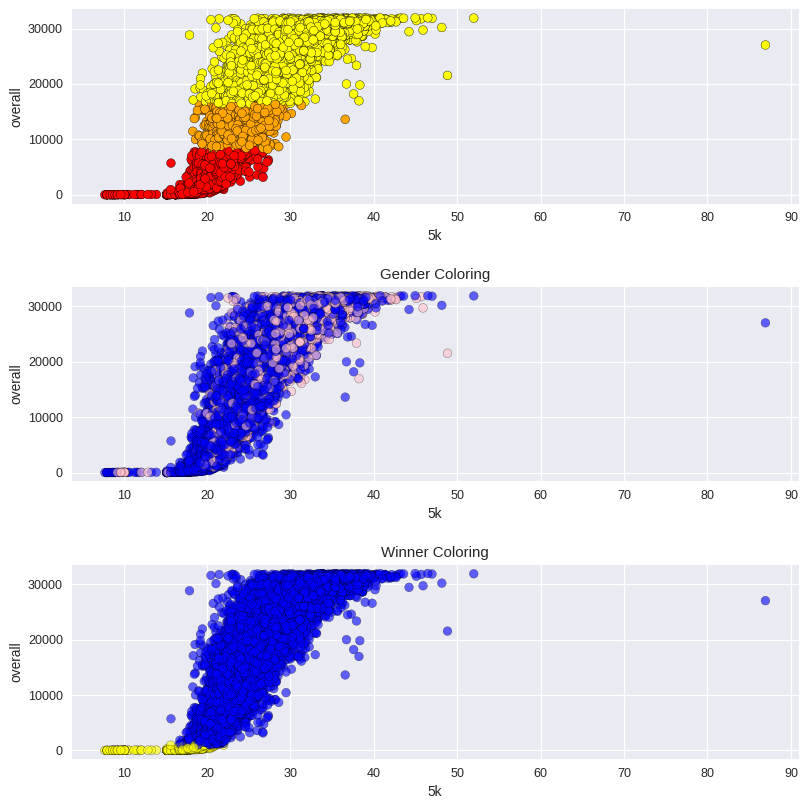

In [236]:
chcktwo(marathon, '5k', 'overall', df2)

Number of clusters estimated by MeanShift: 4
Time passed: 0hour:0min:53sec


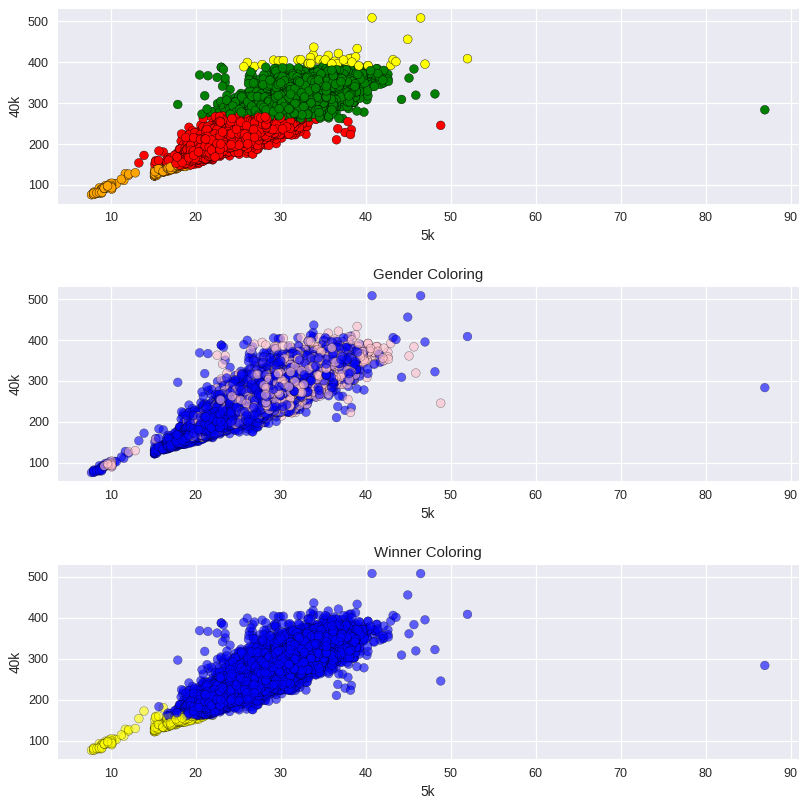

In [237]:
chcktwo(marathon, '5k', '40k', df2)

Number of clusters estimated by MeanShift: 1
Time passed: 0hour:1min:1sec


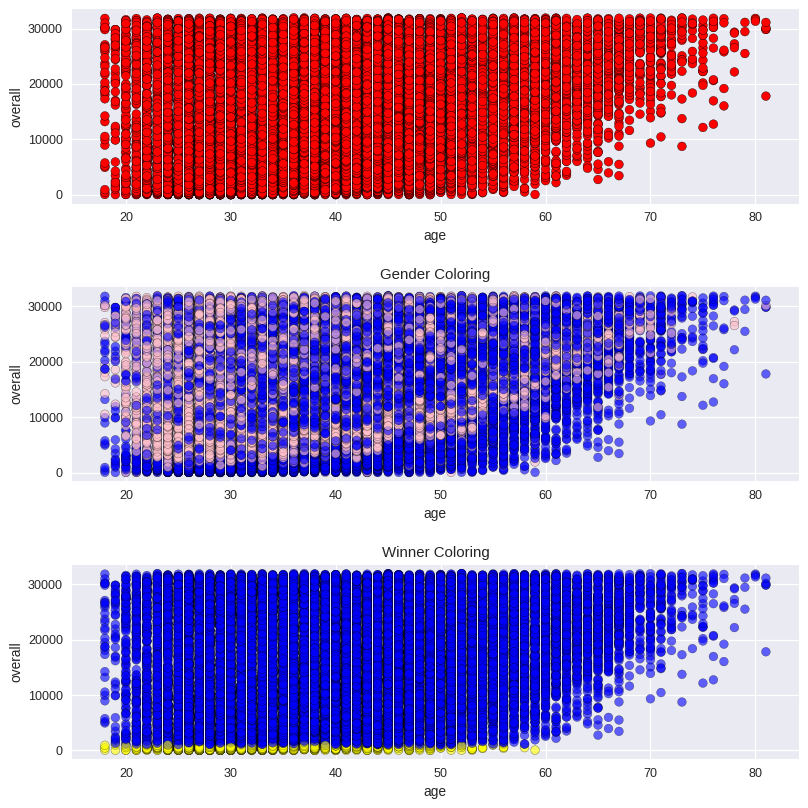

In [238]:
chcktwo(marathon, 'age', 'overall', df2)

Number of clusters estimated by MeanShift: 2
Time passed: 0hour:0min:59sec


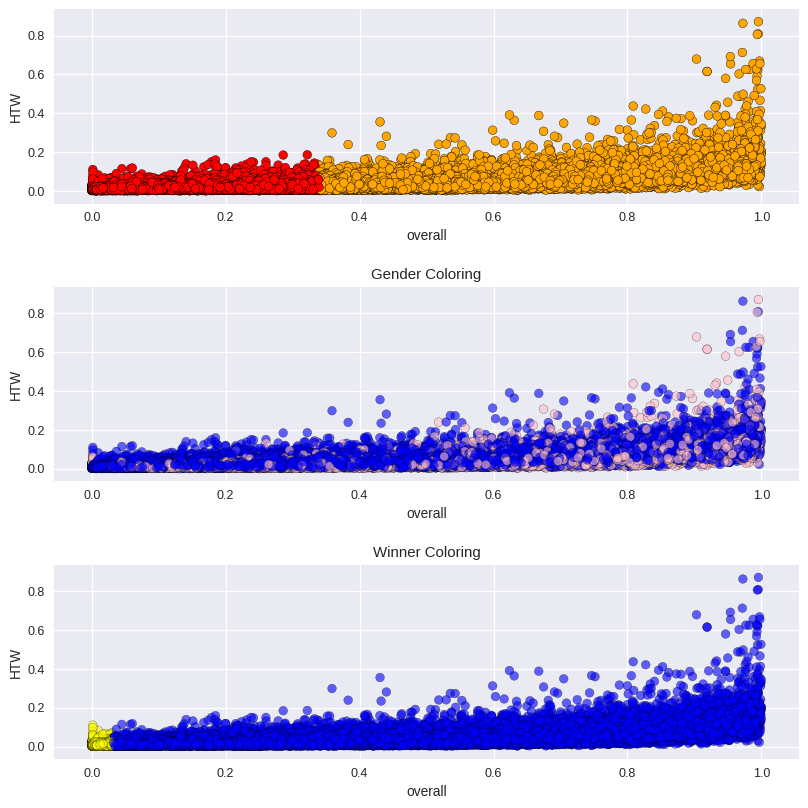

In [239]:
chcktwo(marathon, 'overall', 'HTW', marathon)

Number of clusters estimated by MeanShift: 3
Time passed: 0hour:0min:52sec


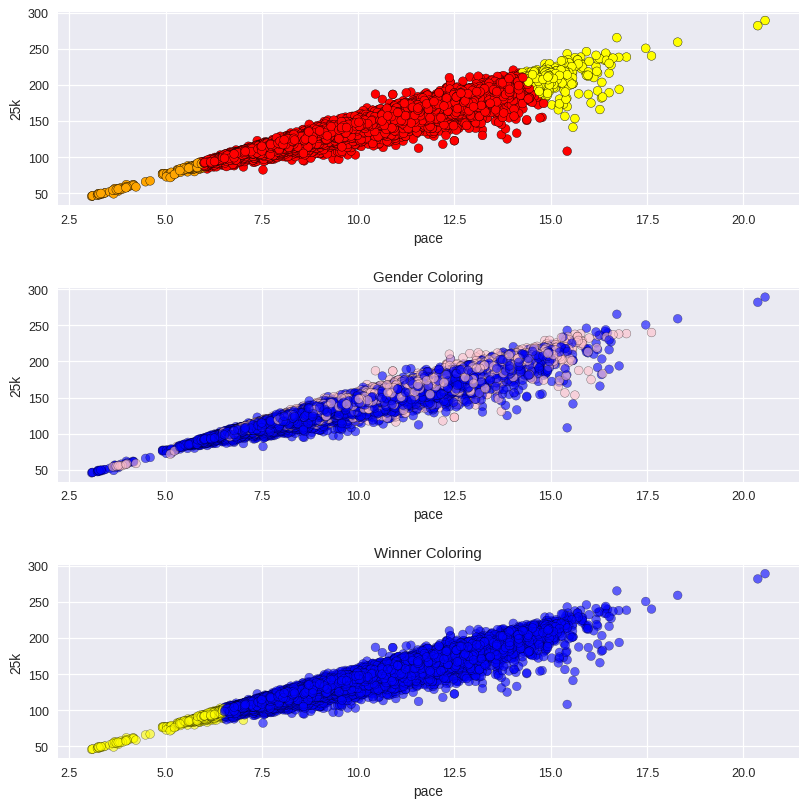

In [240]:
chcktwo(marathon, 'pace', '25k', df2)

Number of clusters estimated by MeanShift: 4
Time passed: 0hour:0min:52sec


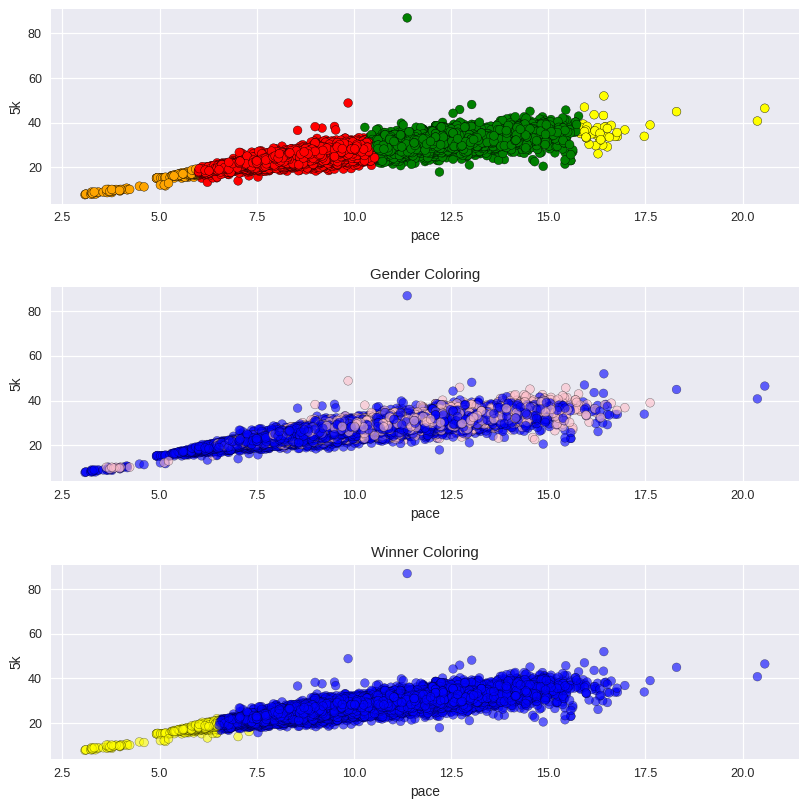

In [241]:
chcktwo(marathon, 'pace', '5k', df2)

Number of clusters estimated by MeanShift: 4
Time passed: 0hour:0min:54sec


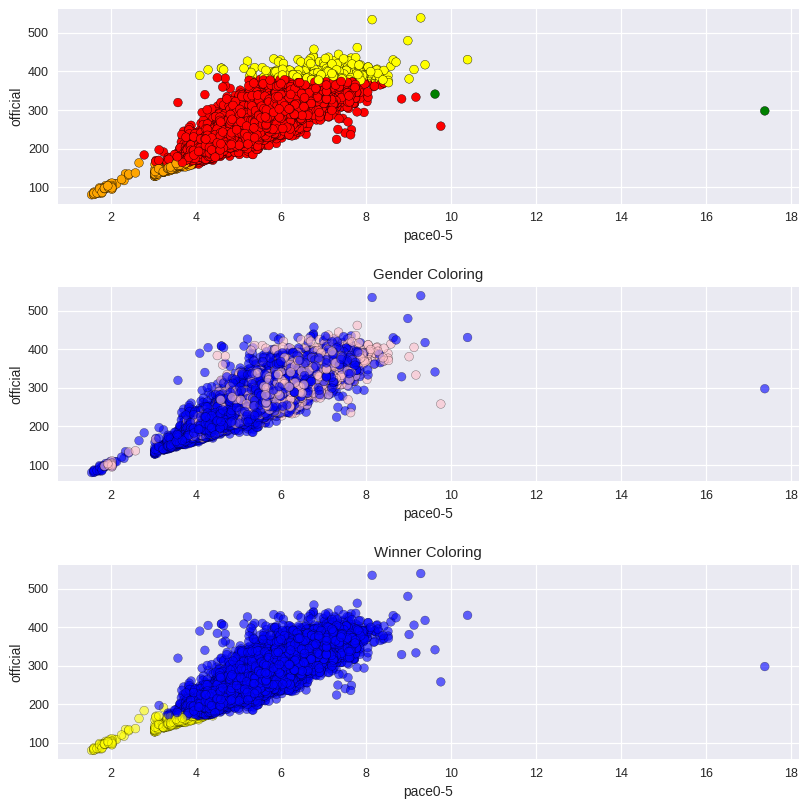

In [242]:
chcktwo(marathon, 'pace0-5', 'official', df2)

Number of clusters estimated by MeanShift: 7
Time passed: 0hour:0min:55sec


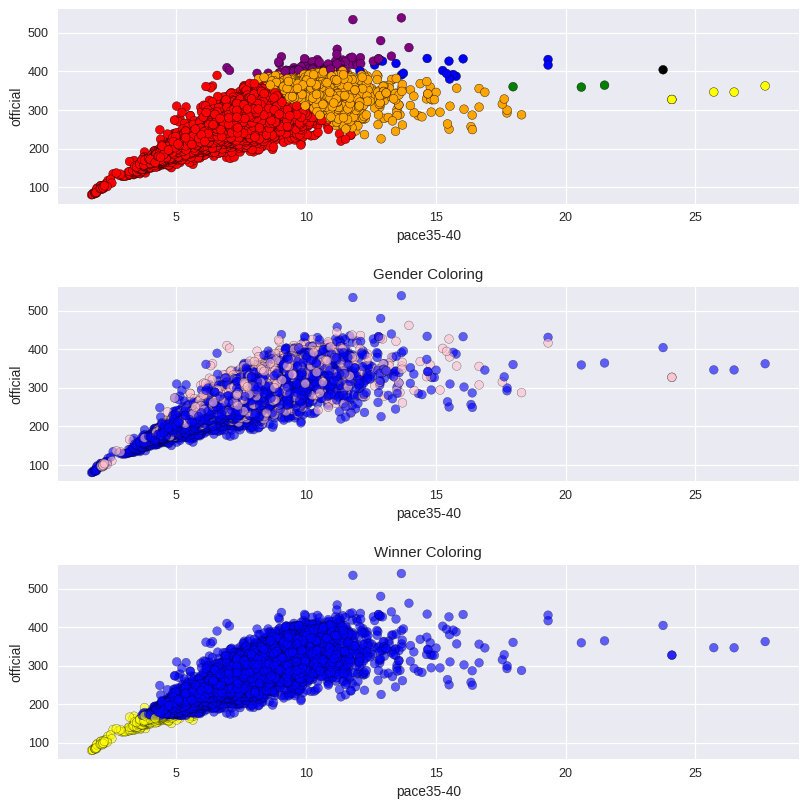

In [243]:
chcktwo(marathon, 'pace35-40', 'official', df2)

Number of clusters estimated by MeanShift: 1
Time passed: 0hour:0min:58sec


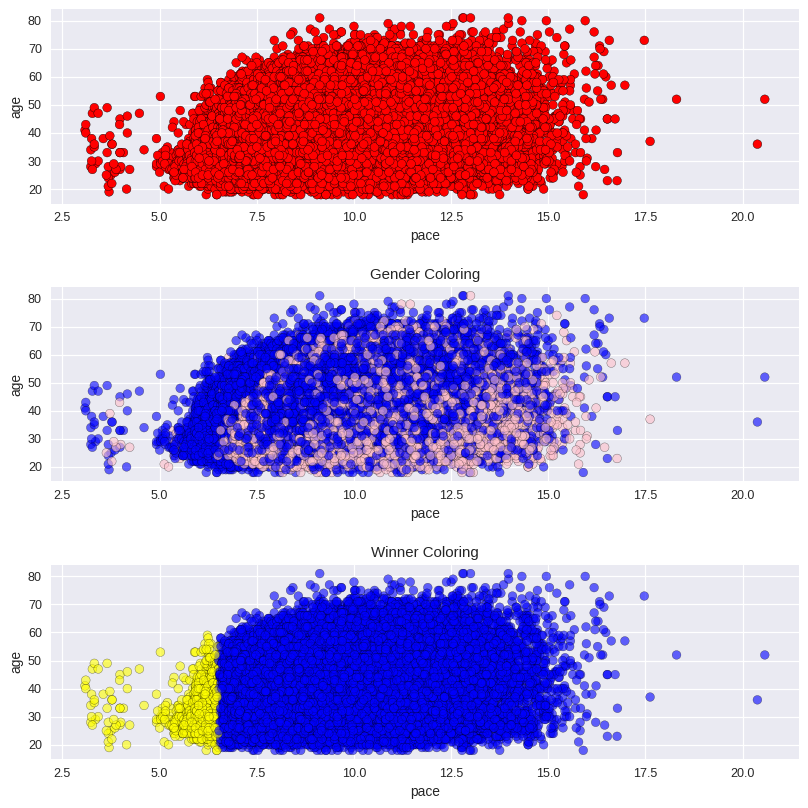

In [244]:
chcktwo(marathon, 'pace', 'age', df2)

Number of clusters estimated by MeanShift: 10
Time passed: 0hour:1min:0sec


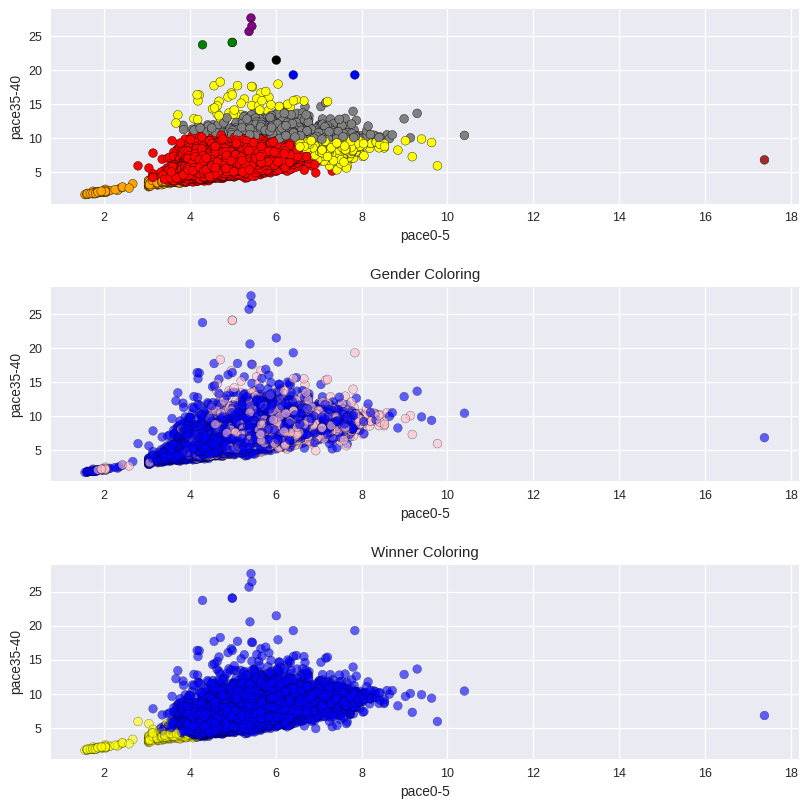

In [245]:
chcktwo(marathon, 'pace0-5', 'pace35-40', df2)